In [5]:
import skrf as rf
from skrf.constants import K_BOLTZMANN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.interpolate import interp1d
from devices.devices_lib import make_cavity__with_antennas_network # From Chirstan Boutan's PNNL team
import components as cmp # From Jihee
import os.path

%matplotlib inline

In [93]:
freq = rf.frequency.Frequency(start=0.5, stop=1.5, npoints=1001, unit='ghz', sweep_type='lin')
Troom = 290

In [94]:
###############################
##### Component Functions   ###
###############################
#(From Jihee's components.py and analyis_run1C_tsys.py)

pow_to_dbm = lambda x: 10*np.log(x/1e-3)

dBm_to_W = lambda p_dBm: 10**(p_dBm/10)/1000
power_in_dBm_per_Hz_to_temp = lambda p: dBm_to_W(p)/K_BOLTZMANN

### Function to read network in noisy environment ###
def read_in_noisy_network(ntw,freq_interp,Tphys):
    ntw_interp = ntw.interpolate(freq_interp, kind='cubic')
    ntw_interp_noisy = rf.NoisyNetwork(ntw_interp)
    ntw_interp_noisy.noise_source(source='passive',T0 = Tphys)

    return ntw_interp_noisy

### Function to make coaxial cable with coaxial line and SMA connector sample ###
def make_coax_cable(c_type,freq,len_m,Tphys):
        
    if c_type=='RG405U':
        ntw_coax_RT = cmp.cable_RG405U(freq,len_m)
        ntw_coax_cryo = cmp.RT2Cryo(ntw_coax_RT)
        # ntw_coax_cryo = ntw_coax_RT
        # ntw_SMA_RT = cmp.cable_RG405U(freq,0.04)
        ntw_SMA_RT = cmp.SMA_RG405U(freq,0.015)
        ntw_SMA_cryo = cmp.RT2Cryo(ntw_SMA_RT)
        # ntw_SMA_cryo = ntw_SMA_RT
    elif c_type=='PESR405FL':    
        ntw_coax_RT = cmp.cable_PESR405FL(freq,len_m)
        ntw_coax_cryo = cmp.RT2Cryo(ntw_coax_RT)
        # ntw_coax_cryo = ntw_coax_RT
        # ntw_SMA_RT = cmp.cable_PESR405FL(freq,0.04)
        ntw_SMA_RT = cmp.SMA_PESR405FL(freq,0.015)
        ntw_SMA_cryo = cmp.RT2Cryo(ntw_SMA_RT)
        # ntw_SMA_cryo = ntw_SMA_RT
    elif c_type=='NbTi085':
        ntw_coax_cryo = cmp.cable_NbTi085(freq,len_m)
        ntw_SMA_cryo = cmp.cable_NbTi085(freq,0.015)
    else:
        print('Error: Proper cable type is missing')

    noisy_ntw_coax = read_in_noisy_network(ntw_coax_cryo,freq,Tphys)
    noisy_ntw_SMA = read_in_noisy_network(ntw_SMA_cryo, freq, Tphys)
    
    assmb_cable = rf.MultiNoisyNetworkSystem()

    noisy_ntw_SMA.add_noise_polar(1e-6, 0.5)
    assmb_cable.add(noisy_ntw_SMA,'SMA1')
    assmb_cable.add(noisy_ntw_coax,'coax')
    noisy_ntw_SMA.add_noise_polar(1e-6, 0.55)
    assmb_cable.add(noisy_ntw_SMA,'SMA2')

    assmb_cable.connect('SMA1',2, 'coax',1)
    assmb_cable.connect('coax',2, 'SMA2',1)

    assmb_cable.external_port('SMA1',1,1)
    assmb_cable.external_port('SMA2',2,2)

    noisy_ntw_cable = assmb_cable.reduce()
    noisy_ntw_cable = read_in_noisy_network(noisy_ntw_cable,freq,Tphys)
        
    return noisy_ntw_cable  

In [95]:
# Creates a function of frequency that returns amplifier noise figure amplitudu
def gen_ZX60_33LN_S_NF_func(ZX60_33LN_NF_loc):
    
    # read in nf data from a csv
    # convert noise figure in db to amplitude
    # Make a new column with frequency in GHz
    # Interpolate noise figure as a function of frequency
    
    noise_figure_data2 = pd.read_csv(ZX60_33LN_NF_loc , header = 'infer')
    noise_figure_data2['NF Amplitude'] = 10**(noise_figure_data2['Noise Figure (5V)']/10)
    noise_figure_data2['Frequency (GHz)'] = noise_figure_data2['Frequency (MHz)']/1e3
    NF_Func2 = interp1d(noise_figure_data2['Frequency (GHz)'],noise_figure_data2['NF Amplitude'])#,fill_value=1000) # <- extrapolate ok here?
    
    return NF_Func2

def return_ZX60_33LN_params(Amp_path,Amp_name,freq,sat_check=False,vendor=True,Temp=290):
    
    # create amplifier from manufacturer's s2p file
    
    ZX60_33LN_NF_loc = r'/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data/ZX60-33LN-S+NF_DATA.csv'
    
    Tphys = Temp
    
    Amp_loc = os.path.join(Amp_path,Amp_name)
    amp_sparam = rf.Network(Amp_loc)
    amp_sparam = amp_sparam.interpolate(freq,kind='cubic')
    amp_sparam  = rf.NoisyNetwork(amp_sparam)
    amp_sparam.noise_source(source='passive',T0=Tphys) # <-- why do we need this is we are specifying the cs matrix from the datasheet?
    
    # generate noise figure function
    
    #try:
    NF_func = gen_ZX60_33LN_S_NF_func(ZX60_33LN_NF_loc)
    nfig = NF_func(freq.f/1e9)
    #except:
       # print('error')
       # return
    
    # use noise figure function to specify noise covariance matrix
    # cs}_ii = k_B T_0 S A S^dagger }_ii (F_i - 1)
        
    Tnoise = rf.NetworkNoiseCov.Tnoise(freq.f,Tphys) # <-- where is this noise temperature used?
    
    I = np.identity(np.shape(amp_sparam.s)[1])
    AS = np.matmul(I,np.conjugate(amp_sparam.s.swapaxes(1,2)))
    SAS = np.matmul(amp_sparam.s,AS)
    
    amp_sparam.cs[:,0,0] = (nfig - 1) * K_BOLTZMANN * 290 * SAS[:,0,0]
    
    I = np.identity(np.shape(amp_sparam.s)[1])
    AS = np.matmul(I,np.conjugate(amp_sparam.s.swapaxes(1,2)))
    SAS = np.matmul(amp_sparam.s,AS)
    
    amp_sparam.cs[:,1,1] = (nfig-1) * K_BOLTZMANN * 290 * SAS[:,1,1]
    
    amp_sparam.cs[:,0,1] = np.zeros_like(amp_sparam.cs[:,1,1])
    amp_sparam.cs[:,1,0] = amp_sparam.cs[:,0,1]
    
    return amp_sparam
    

In [129]:
def plot_power_cav2sa_1(termi_temps):
    
    """ Plots noise power spectral density for a cavity with one antenna terminated with a terminator of temperature termi_temp. The cavity is connected to two amplifiers."""
    
    def setup_ntw(termi_temp):
        
        #Amplifier
        amp_path = '/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data'
        amp_name = 'ZX60-33LNR-S+_UNIT1_.s2p' #Our amplifier is ZX60-33LN-S+, gain of LNR ~0.1 dB less at 1 Ghz

        amp_sparam = return_ZX60_33LN_params(amp_path,amp_name,freq)
    
        noisy_ntw_amp1 = amp_sparam
        noisy_ntw_amp2 = amp_sparam
        
        #Cavity
    
        freq_cavity = 1e9
        R_cavity=1_000 # resistance 
        Q_cavity=2_000

        start_freq = 0.5e9
        stop_freq = 1.5e9

        ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity) # [[What are the N's here?]]
        noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, Troom)

        # #Circulator
        # ntw_circ1 = cmp.create_ideal_circulator2(freq)
        # noisy_ntw_circ1 = read_in_noisy_network(ntw_circ1, freq, Troom)


        #Terminator
        ntw_termi = cmp.create_terminator(freq,Gamma_0=0.048) # [[What determines gamma_0 here?]]
        noisy_ntw_termi = read_in_noisy_network(ntw_termi, freq, termi_temp) ## <------ function parameter


        #Cables
        LEN_CABLE1 = 0.01 #m
        LEN_CABLE2 = 0.01 #m

        noisy_ntw_cable_1 = make_coax_cable('RG405U',freq,LEN_CABLE1,Troom)
        noisy_ntw_cable_2 = make_coax_cable('RG405U',freq,LEN_CABLE2,Troom)

        ##### Circuit diagram
        
        # [termi]-1 <-> 2-[Cavity]-1 <-> 2-[cable1]-1 <-> 2-[amp1]-1 <-> 2-[amp2]-1 <-> 2-[Cable2]-1 (out)                                          
          
        # Cavity -> Second Circulator

        mnns_cav2sa = rf.MultiNoisyNetworkSystem()
        
        mnns_cav2sa.add(noisy_ntw_termi,'termi')
        mnns_cav2sa.add(noisy_ntw_cav,'cavity')
        mnns_cav2sa.add(noisy_ntw_cable_1,'cable1')
        mnns_cav2sa.add(noisy_ntw_amp1,'amp1') 
        mnns_cav2sa.add(noisy_ntw_amp2,'amp2') 
        mnns_cav2sa.add(noisy_ntw_cable_2,'cable2')

        mnns_cav2sa.connect('termi',1,'cavity',2)
        mnns_cav2sa.connect('cavity',1,'cable1',2)
        mnns_cav2sa.connect('cable1',1,'amp1',2)
        mnns_cav2sa.connect('amp1',1,'amp2',2)
        mnns_cav2sa.connect('amp2',1,'cable2',1)

        mnns_cav2sa.external_port('cable2',2,1)

        assem_cav2sa = mnns_cav2sa.reduce()
        
        return assem_cav2sa
        
    def make_plots():
        
        fig, axs = plt.subplots(2)

        for termi_temp in termi_temps:
            
            ntw = setup_ntw(termi_temp)
            
            #### Noise power
            
            center = 1000
            xmin = center - 5
            xmax = center + 5
            
            axs[0].set_xlim(xmin,xmax)
            axs[0].plot(freq.f/1e6,10*np.log10(abs(ntw.cs[:,0,0])/.001),label=termi_temp)
            axs[0].set_xlabel('Frequency [MHz]')
            axs[0].set_ylabel('Noise Power \n Spectral\n  Density (dBm/Hz)')
            axs[0].set_title(f' Termi -> Cavity -> Amp')
            axs[0].legend()
            
            #### Noise temperature
            
            I = np.identity(np.shape(ntw.s)[1])
            SS  = np.matmul(ntw.s, np.conjugate(ntw.s))
            I_SS = (I-SS)

            # Bosma's theorem; eq.9 from Garcia-Garcia
            T_n_1  = np.abs(ntw.cs[:,0,0])/(K_BOLTZMANN*np.abs(I_SS[:,0,0])) 
            # From Garcia-Garcis, eq. 12 with modified version only with |S_11|^2
            T_n_2  = np.abs(ntw.cs[:,0,0])/(K_BOLTZMANN*np.abs(1-(ntw.s[:,0,0])**2)) 
            # ==> I see there is some discrepancy. My feeling is to go with the second version (eq.12) since it is more explanatory for 
            
            axs[1].set_xlim(xmin,xmax)
            axs[1].plot(freq.f/1e6,T_n_2,label=termi_temp)
            axs[1].set_xlabel('Frequency [MHz]')
            axs[1].set_ylabel('Noise \n Temperature (K)')
            #axs[1].legend()
        
    make_plots()


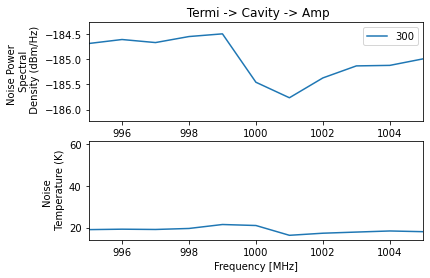

In [130]:
plot_power_cav2sa_1([300])

In [142]:
def plot_power_cav2sa_2(termi_temps):
    
    """Plots noise power spectral density for cavity -> terminated circulator at temp termi_temp -> amp."""
    
    def setup_ntw(termi_temp):
        
        #Amplifier
        amp_path = '/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data'
        amp_name = 'ZX60-33LNR-S+_UNIT1_.s2p' #Our amplifier is ZX60-33LN-S+, gain of LNR ~0.1 dB less at 1 Ghz

        amp_sparam = return_ZX60_33LN_params(amp_path,amp_name,freq)
    
        noisy_ntw_amp_1 = amp_sparam
        noisy_ntw_amp_2 = amp_sparam
        
        #Cavity
    
        freq_cavity = 1e9
        R_cavity=1_000 # resistance 
        Q_cavity=2_000

        start_freq = 0.5e9
        stop_freq = 1.5e9

        ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity) # [[What are the N's here?]]
        noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, Troom)

        #Circulator
        ntw_circ1 = cmp.create_ideal_circulator2(freq)
        noisy_ntw_circ1 = read_in_noisy_network(ntw_circ1, freq, Troom)


        #Terminator
        ntw_termi = cmp.create_terminator(freq,Gamma_0=0.048) # [[What determines gamma_0 here?]]
        noisy_ntw_termi = read_in_noisy_network(ntw_termi, freq, termi_temp) ## <------ function parameter
        noisy_ntw_termi_2 = read_in_noisy_network(ntw_termi, freq, Troom)

        #Cables
        LEN_CABLE1 = 0.01 #m
        LEN_CABLE2 = 0.01 #m
        LEN_CABLE3 = 0.01 #m
        LEN_CABLE4 = 0.01 #m

        noisy_ntw_cable_1 = make_coax_cable('RG405U',freq,LEN_CABLE1,Troom)
        noisy_ntw_cable_2 = make_coax_cable('RG405U',freq,LEN_CABLE2,Troom)
        noisy_ntw_cable_3 = make_coax_cable('RG405U',freq,LEN_CABLE3,Troom)
        noisy_ntw_cable_4 = make_coax_cable('RG405U',freq,LEN_CABLE4,Troom)

        # Circuit diagram
        
        # (termi) - 2-[Cavity]-1 <-> 2-[cable1]-1 <-> 3-(circ1)-1 <-> 2-[cable3]-1 <-> 2-[amp 1]-1 <-> 2-[amp 2]-1 <-> 2-[cable4]-1 (p1)
        #                                              2                               
        #                                              1                               
        #                                           [cable2]                          
        #                                              2                                                
        #                                           _termi_  
        
        
        # Cavity -> Spectrum Analyzer

        mnns_cav2sa = rf.MultiNoisyNetworkSystem()

        mnns_cav2sa.add(noisy_ntw_termi_2,'termi2')
        mnns_cav2sa.add(noisy_ntw_cav,'cavity')
        mnns_cav2sa.add(noisy_ntw_cable_1,'cable1')
        mnns_cav2sa.add(noisy_ntw_circ1,'circ1') #clockwise
        mnns_cav2sa.add(noisy_ntw_cable_2,'cable2')
        mnns_cav2sa.add(noisy_ntw_termi,'termi')
        mnns_cav2sa.add(noisy_ntw_cable_3,'cable3')
        mnns_cav2sa.add(noisy_ntw_amp_1,'amp1')
        mnns_cav2sa.add(noisy_ntw_amp_2,'amp2')
        mnns_cav2sa.add(noisy_ntw_cable_3,'cable4')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns_cav2sa.connect('termi2',1,'cavity',2)
        mnns_cav2sa.connect('cavity',1,'cable1',2)
        mnns_cav2sa.connect('cable1',1,'circ1',3)
        mnns_cav2sa.connect('circ1',2,'cable2',1)
        mnns_cav2sa.connect('cable2',2,'termi',1)
        mnns_cav2sa.connect('circ1',1,'cable3',2)
        mnns_cav2sa.connect('cable3',1,'amp1',2)
        mnns_cav2sa.connect('amp1',1,'amp2',1)
        mnns_cav2sa.connect('amp2',2,'cable4',2)


        mnns_cav2sa.external_port('cable4',1,1)

        assem_cav2sa = mnns_cav2sa.reduce()
        
        return assem_cav2sa
        
    def make_plots():
        
        fig, axs = plt.subplots(2)

        for termi_temp in termi_temps:
            
            ntw = setup_ntw(termi_temp)
            
            #### Noise power
            
            center = 1000
            xmin = center - 5
            xmax = center + 5
            
            axs[0].set_xlim(xmin,xmax)
            axs[0].plot(freq.f/1e6,10*np.log10(abs(ntw.cs[:,0,0])/.001),label=termi_temp)
            axs[0].set_xlabel('Frequency [MHz]')
            axs[0].set_ylabel('Noise Power \n Spectral\n  Density (dBm/Hz)')
            axs[0].set_title(f' Cavity -> Circ -> Amp')
            axs[0].legend()
            
            #### Noise temperature
            
            I = np.identity(np.shape(ntw.s)[1])
            SS  = np.matmul(ntw.s, np.conjugate(ntw.s))
            I_SS = (I-SS)

            # Bosma's theorem; eq.9 from Garcia-Garcia
            T_n_1  = np.abs(ntw.cs[:,0,0])/(K_BOLTZMANN*np.abs(I_SS[:,0,0])) 
            # From Garcia-Garcis, eq. 12 with modified version only with |S_11|^2
            T_n_2  = np.abs(ntw.cs[:,0,0])/(K_BOLTZMANN*np.abs(1-(ntw.s[:,0,0])**2)) 
            # ==> I see there is some discrepancy. My feeling is to go with the second version (eq.12) since it is more explanatory for 
            
            axs[1].set_xlim(xmin,xmax)
            axs[1].plot(freq.f/1e6,T_n_2,label=termi_temp)
            axs[1].set_xlabel('Frequency [MHz]')
            axs[1].set_ylabel('Noise \n Temperature (K)')
            #axs[1].legend()
        
    make_plots()

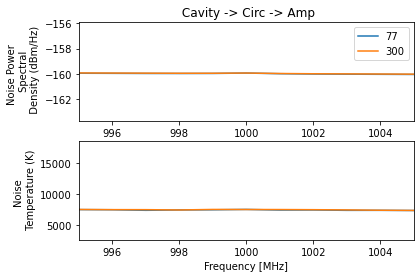

In [143]:
plot_power_cav2sa_2([77,300])

In [118]:
#Amplifier
amp_path = '/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data'
amp_name = 'ZX60-33LNR-S+_UNIT1_.s2p' #Our amplifier is ZX60-33LN-S+, gain of LNR ~0.1 dB less at 1 Ghz

amp_sparam = return_ZX60_33LN_params(amp_path,amp_name,freq)

noisy_ntw_amp1 = amp_sparam
noisy_ntw_amp2 = amp_sparam

#Cavity
freq_cavity = 1e9
R_cavity=1_000 # resistance 
Q_cavity=2_000

start_freq = 0.5e9
stop_freq = 1.5e9

ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity) # [[What are the N's here?]]
noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, Troom)

# #Circulator
# ntw_circ1 = cmp.create_ideal_circulator2(freq)
# noisy_ntw_circ1 = read_in_noisy_network(ntw_circ1, freq, Troom)


#Terminator
ntw_termi = cmp.create_terminator(freq,Gamma_0=0.048) # [[What determines gamma_0 here?]]
noisy_ntw_termi = read_in_noisy_network(ntw_termi, freq, Troom) ## <------ function parameter


#Cables
LEN_CABLE1 = 0.01 #m
LEN_CABLE2 = 0.01 #m

noisy_ntw_cable_1 = make_coax_cable('RG405U',freq,LEN_CABLE1,Troom)
noisy_ntw_cable_2 = make_coax_cable('RG405U',freq,LEN_CABLE2,Troom)

##### Circuit diagram

# [termi]-1 <-> 2-[Cavity]-1 <-> 2-[cable1]-1 <-> 2-[amp1]-1 <-> 2-[amp2]-1 <-> 2-[Cable2]-1 (out)                                          

# Cavity -> Second Circulator

mnns_cav2sa = rf.MultiNoisyNetworkSystem()

mnns_cav2sa.add(noisy_ntw_termi,'termi')
mnns_cav2sa.add(noisy_ntw_cav,'cavity')
mnns_cav2sa.add(noisy_ntw_cable_1,'cable1')
mnns_cav2sa.add(noisy_ntw_amp1,'amp1') 
mnns_cav2sa.add(noisy_ntw_amp2,'amp2') 
mnns_cav2sa.add(noisy_ntw_cable_2,'cable2')

mnns_cav2sa.connect('termi',1,'cavity',2)
mnns_cav2sa.connect('cavity',1,'cable1',2)
mnns_cav2sa.connect('cable1',1,'amp1',2)
mnns_cav2sa.connect('amp1',1,'amp2',2)
mnns_cav2sa.connect('amp2',1,'cable2',2)

mnns_cav2sa.external_port('cable2',1,1)

assem_cav2sa = mnns_cav2sa.reduce()

T_n_2  = np.abs(assem_cav2sa.cs[:,0,0])/(K_BOLTZMANN*np.abs(1-(assem_cav2sa.s[:,0,0])**2))
T_n_2[-1]

19.788810762746767

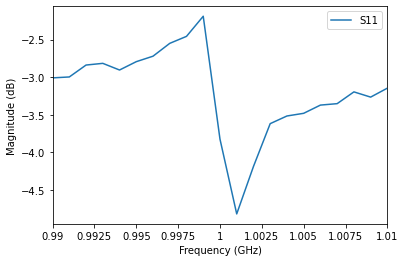

In [120]:
assem_cav2sa['.99-1.01Ghz'].plot_s_db()

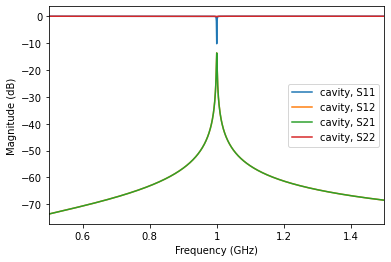

In [121]:
noisy_ntw_cav.plot_s_db()

In [83]:
#Terminator
ntw_termi = cmp.create_terminator(freq,Gamma_0=0.048) # what is our terminator gamma_0?
noisy_ntw_termi = read_in_noisy_network(ntw_termi, freq, Troom)


#Cables
LEN_CABLE1 = 0.3 #m
LEN_CABLE2 = 0.3 #m

noisy_ntw_cable_1 = make_coax_cable('RG405U',freq,LEN_CABLE1,Troom) # <--- cable noise?
noisy_ntw_cable_2 = make_coax_cable('RG405U',freq,LEN_CABLE2,Troom)


#Amplifier
amp_path = '/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data'
amp_name = 'ZX60-33LNR-S+_UNIT1_.s2p' #Our amplifier is ZX60-33LN-S+, gain of LNR ~0.1 dB less at 1 Ghz

amp_sparam = return_ZX60_33LN_params(amp_path,amp_name,freq)

amp1 = amp_sparam
amp2 = amp_sparam


# Assemble circuit
# terminator -> cable 1 -> amp 1 -> amp 2 -> cable 2 -> Spectrum analyzer
mnns_simple_circ = rf.MultiNoisyNetworkSystem()

mnns_simple_circ.add(noisy_ntw_cable_1,'cable1')
mnns_simple_circ.add(noisy_ntw_cable_2,'cable2')
mnns_simple_circ.add(noisy_ntw_termi,'termi')
mnns_simple_circ.add(amp1,'amp1')
mnns_simple_circ.add(amp2,'amp2')

mnns_simple_circ.connect('termi',1,'cable1',1)
mnns_simple_circ.connect('cable1',2,'amp1',1)
mnns_simple_circ.connect('amp1',2,'amp2',1)
mnns_simple_circ.connect('amp2',2,'cable2',1)

mnns_simple_circ.external_port('cable2',2,1)

assem_simple_circ = mnns_simple_circ.reduce()


# From Garcia-Garcis, eq. 12 with modified version only with |S_11|^2
T_n_simple_circ_2  = np.abs(assem_simple_circ.cs[:,0,0])/(K_BOLTZMANN*np.abs(1-(assem_simple_circ.s[:,0,0])**2)) 
# ==> I see there is some discrepancy. My feeling is to go with the second version (eq.12) since it is more explanatory for 

T_n_simple_circ_2[-1]

2092989.1588444163

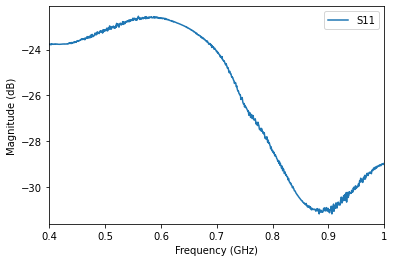

In [85]:
assem_simple_circ.plot_s_db()

In [ ]:
#Measured S-Params

S_circ_db = np.array([[-6.12,-1.3,-12.03],
                      [-4.738,-6.832,-11.79]
                      [-27.025,-5.353,-6.778]])


    
    

### Simulating circulator and cavity circuit lab setups (3/17/22)

In [176]:
def make_pink_circuit():
    """ 
    circulator ports: 1: SA, 2: open, 3: 300k terminator
    Using terminator with gamma_0 = 1 for open (full in-phase reflection)
    """
    
    #Amplifier
    amp_path = '/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data'
    amp_name = 'ZX60-33LNR-S+_UNIT1_.s2p' #Our amplifier is ZX60-33LN-S+, gain of LNR ~0.1 dB less at 1 Ghz

    amp_sparam = return_ZX60_33LN_params(amp_path,amp_name,freq)

    noisy_ntw_amp_1 = amp_sparam
    noisy_ntw_amp_2 = amp_sparam

    #Cavity

    freq_cavity = 1.315e9 # Measured
    R_cavity= 1_000 # [[Not measured, what is a reasonable value for cavity resistance?]]
    Q_cavity= 666.23 # Measured

    start_freq = 0.5e9
    stop_freq = 1.5e9

    ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity) # [[What are the N's here?]]
    noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, Troom)

    #Circulator
    ntw_circ_1 = cmp.create_ideal_circulator2(freq)
    noisy_ntw_circ_1 = read_in_noisy_network(ntw_circ_1, freq, Troom)


    #Terminator
    ntw_termi_1 = cmp.create_terminator(freq,Gamma_0=0.048) # [[not measured]]
    noisy_ntw_termi_1 = read_in_noisy_network(ntw_termi_1, freq, Troom) 
    
    ntw_termi_open = cmp.create_terminator(freq,Gamma_0=1)
    noisy_ntw_termi_open = read_in_noisy_network(ntw_termi_open, freq, Troom) 


    # Circuit diagram

    # (SA) - 1 - [circ] - 2 - 1 [open]
    #              3
    #              |
    #              1
    #           [termi]

    mnns = rf.MultiNoisyNetworkSystem()

    mnns.add(noisy_ntw_termi_1,'termi')
    mnns.add(noisy_ntw_amp_1,'amp1')
    mnns.add(noisy_ntw_amp_2,'amp2')
    mnns.add(noisy_ntw_circ_1,'circ')
    mnns.add(noisy_ntw_termi_open,'open')


    # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
    mnns.connect('open',1,'circ',2)
    mnns.connect('termi',1,'circ',3)
    mnns.connect('circ',1,'amp1',1)
    mnns.connect('amp1',2,'amp2',1)

    mnns.external_port('amp2',2,1)

    assem_mnns = mnns.reduce()

    return assem_mnns
    

In [199]:
def make_blue_circuit():
    """ 
    circulator ports: 1: SA, 2: cavity, 3: open
    Using terminator with gamma_0 = 1 for open
    One cavity antenna terminated with open 
    """
    
    #Amplifier
    amp_path = '/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data'
    amp_name = 'ZX60-33LNR-S+_UNIT1_.s2p' #Our amplifier is ZX60-33LN-S+, gain of LNR ~0.1 dB less at 1 Ghz

    amp_sparam = return_ZX60_33LN_params(amp_path,amp_name,freq)

    noisy_ntw_amp_1 = amp_sparam
    noisy_ntw_amp_2 = amp_sparam

    #Cavity

    freq_cavity = 1.315e9 # Measured
    R_cavity= 1_000 # [[Not measured, what is a reasonable value for cavity resistance?]]
    Q_cavity= 666.23 # Measured

    start_freq = 0.5e9
    stop_freq = 1.5e9

    ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity) # [[What are the N's here?]]
    noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, Troom)

    #Circulator
    ntw_circ_1 = cmp.create_ideal_circulator2(freq)
    noisy_ntw_circ_1 = read_in_noisy_network(ntw_circ_1, freq, Troom)


    #Terminator
    ntw_termi_1 = cmp.create_terminator(freq,Gamma_0=0.048) # [[not measured]]
    noisy_ntw_termi_1 = read_in_noisy_network(ntw_termi_1, freq, Troom) 
    
    ntw_termi_open = cmp.create_terminator(freq,Gamma_0=1)
    noisy_ntw_termi_open = read_in_noisy_network(ntw_termi_open, freq, Troom) 


    # Circuit diagram

    # (SA) - 1 - [circ] - 2 - 1 [cavity] 2 - 1 [termi]
    #              3
    #              |
    #              1
    #           [open]

    mnns = rf.MultiNoisyNetworkSystem()

    mnns.add(noisy_ntw_cav,'cav')
    mnns.add(noisy_ntw_amp_1,'amp1')
    mnns.add(noisy_ntw_amp_2,'amp2')
    mnns.add(noisy_ntw_circ_1,'circ')
    mnns.add(noisy_ntw_termi_1,'termi1')
    mnns.add(noisy_ntw_termi_open,'open')


    # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
    mnns.connect('termi1',1,'cav',2)
    mnns.connect('cav',1,'circ',2)
    mnns.connect('circ',3,'open',1)
    mnns.connect('circ',1,'amp1',1)
    mnns.connect('amp1',2,'amp2',1)

    mnns.external_port('amp2',2,1)

    assem_mnns = mnns.reduce()

    return assem_mnns

In [209]:
def make_yellow_circuit():
    """ 
    circulator ports: 1: SA, 2: cavity, 3: 300k terminator
    Using terminator with gamma_0 = 0 for open
    """
    #Amplifier

    amp_path = '/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data'
    amp_name = 'ZX60-33LNR-S+_UNIT1_.s2p' #Our amplifier is ZX60-33LN-S+, gain of LNR ~0.1 dB less at 1 Ghz

    amp_sparam = return_ZX60_33LN_params(amp_path,amp_name,freq)

    noisy_ntw_amp_1 = amp_sparam
    noisy_ntw_amp_2 = amp_sparam

    #Cavity

    freq_cavity = 1.315e9 # Measured
    R_cavity= 1_000 # [[Not measured, what is a reasonable value for cavity resistance?]]
    Q_cavity= 666.23 # Measured

    start_freq = 0.5e9
    stop_freq = 1.5e9

    ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity) # [[What are the N's here?]]
    noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, Troom)

    #Circulator
    ntw_circ_1 = cmp.create_ideal_circulator2(freq)
    noisy_ntw_circ_1 = read_in_noisy_network(ntw_circ_1, freq, Troom)


    #Terminator
    ntw_termi_1 = cmp.create_terminator(freq,Gamma_0=0.048) # [[not measured]]
    noisy_ntw_termi_1 = read_in_noisy_network(ntw_termi_1, freq, Troom) 

    ntw_termi_open = cmp.create_terminator(freq,Gamma_0=1)
    noisy_ntw_termi_open = read_in_noisy_network(ntw_termi_open, freq, Troom) 


    # Circuit diagram

    # (SA) - 1 - [circ] - 2 - 1 [cavity] 2 - 1 [termi1]
    #              3
    #              |
    #              1
    #           [300k termi2]

    mnns = rf.MultiNoisyNetworkSystem()

    mnns.add(noisy_ntw_cav,'cav')
    mnns.add(noisy_ntw_amp_1,'amp1')
    mnns.add(noisy_ntw_amp_2,'amp2')
    mnns.add(noisy_ntw_circ_1,'circ')
    mnns.add(noisy_ntw_termi_1,'termi1')
    mnns.add(noisy_ntw_termi_1,'termi2')


    # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
    mnns.connect('termi1',1,'cav',2)
    mnns.connect('cav',1,'circ',2)
    mnns.connect('circ',3,'termi2',1)
    mnns.connect('circ',1,'amp1',1)
    mnns.connect('amp1',2,'amp2',1)

    mnns.external_port('amp2',2,1)

    assem_mnns = mnns.reduce()

    return assem_mnns
    

In [212]:
def make_red_circuit():
    """ 
    circulator ports: 1: SA, 2: 300k terminator, 3: 300k terminator
    Using terminator with gamma_0 = 1 for open
    """
    #Amplifier

    amp_path = '/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data'
    amp_name = 'ZX60-33LNR-S+_UNIT1_.s2p' #Our amplifier is ZX60-33LN-S+, gain of LNR ~0.1 dB less at 1 Ghz

    amp_sparam = return_ZX60_33LN_params(amp_path,amp_name,freq)

    noisy_ntw_amp_1 = amp_sparam
    noisy_ntw_amp_2 = amp_sparam

    #Cavity

    freq_cavity = 1.315e9 # Measured
    R_cavity= 1_000 # [[Not measured, what is a reasonable value for cavity resistance?]]
    Q_cavity= 666.23 # Measured

    start_freq = 0.5e9
    stop_freq = 1.5e9

    ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity) # [[What are the N's here?]]
    noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, Troom)

    #Circulator
    ntw_circ_1 = cmp.create_ideal_circulator2(freq)
    noisy_ntw_circ_1 = read_in_noisy_network(ntw_circ_1, freq, Troom)


    #Terminator
    ntw_termi_1 = cmp.create_terminator(freq,Gamma_0=0.048) # [[not measured]]
    noisy_ntw_termi_1 = read_in_noisy_network(ntw_termi_1, freq, Troom) 

    ntw_termi_open = cmp.create_terminator(freq,Gamma_0=1)
    noisy_ntw_termi_open = read_in_noisy_network(ntw_termi_open, freq, Troom) 


    # Circuit diagram

    # (SA) - 1 - [circ] - 2 - 1 [termi1]
    #              3
    #              |
    #              1
    #           [300k termi2]

    mnns = rf.MultiNoisyNetworkSystem()

    mnns.add(noisy_ntw_amp_1,'amp1')
    mnns.add(noisy_ntw_amp_2,'amp2')
    mnns.add(noisy_ntw_circ_1,'circ')
    mnns.add(noisy_ntw_termi_1,'termi1')
    mnns.add(noisy_ntw_termi_1,'termi2')


    # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
    mnns.connect('termi1',1,'circ',2)

    mnns.connect('circ',3,'termi2',1)
    mnns.connect('circ',1,'amp1',1)
    mnns.connect('amp1',2,'amp2',1)

    mnns.external_port('amp2',2,1)

    assem_mnns = mnns.reduce()

    return assem_mnns

In [215]:
def make_teal_circuit():
    """ 
    circulator ports: 1: SA, 2: cavity, 3: 77k terminator
    Using terminator with gamma_0 = 1 for open
    """ 
    #Amplifier

    amp_path = '/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data'
    amp_name = 'ZX60-33LNR-S+_UNIT1_.s2p' #Our amplifier is ZX60-33LN-S+, gain of LNR ~0.1 dB less at 1 Ghz

    amp_sparam = return_ZX60_33LN_params(amp_path,amp_name,freq)

    noisy_ntw_amp_1 = amp_sparam
    noisy_ntw_amp_2 = amp_sparam

    #Cavity

    freq_cavity = 1.315e9 # Measured
    R_cavity= 1_000 # [[Not measured, what is a reasonable value for cavity resistance?]]
    Q_cavity= 666.23 # Measured

    start_freq = 0.5e9
    stop_freq = 1.5e9

    ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity) # [[What are the N's here?]]
    noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, Troom)

    #Circulator
    ntw_circ_1 = cmp.create_ideal_circulator2(freq)
    noisy_ntw_circ_1 = read_in_noisy_network(ntw_circ_1, freq, Troom)


    #Terminator
    ntw_termi_1 = cmp.create_terminator(freq,Gamma_0=0.048) # [[not measured]]
    noisy_ntw_termi_1 = read_in_noisy_network(ntw_termi_1, freq, Troom) 
    noisy_ntw_termi_cold = read_in_noisy_network(ntw_termi_1, freq, 77)

    ntw_termi_open = cmp.create_terminator(freq,Gamma_0=1)
    noisy_ntw_termi_open = read_in_noisy_network(ntw_termi_open, freq, Troom) 


    # Circuit diagram

    # (SA) - 1 - [circ] - 2 - 1 [termi1]
    #              3
    #              |
    #              1
    #           [77k termi2]

    mnns = rf.MultiNoisyNetworkSystem()

    mnns.add(noisy_ntw_amp_1,'amp1')
    mnns.add(noisy_ntw_amp_2,'amp2')
    mnns.add(noisy_ntw_circ_1,'circ')
    mnns.add(noisy_ntw_termi_1,'termi1')
    mnns.add(noisy_ntw_termi_cold,'termi_cold')


    # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
    mnns.connect('termi1',1,'circ',2)
    mnns.connect('circ',3,'termi_cold',1)
    mnns.connect('circ',1,'amp1',1)
    mnns.connect('amp1',2,'amp2',1)

    mnns.external_port('amp2',2,1)

    assem_mnns = mnns.reduce()

    return assem_mnns

In [174]:
def plot_power_spectrum_for_1p_ntw(ntw_dict,center,span):
    """ 
    Plots power spectrum for the passed dictionary of 1 port networks with color labels as keys
    center and span in Mhz
    """
    
    fig, ax = plt.subplots()

    for color_label, ntw in ntw_dict.items():
            
        center = center
        xmin = center - span/2
        xmax = center + span/2

        ax.set_xlim(xmin,xmax)
        ax.plot(freq.f/1e6,10*np.log10(abs(ntw.cs[:,0,0])/.001),color = color_label)
        ax.set_xlabel('Frequency [MHz]')
        ax.set_ylabel('Noise Power \n Spectral\n  Density (dBm/Hz)')
        ax.set_title(f'Cavity and circulator configurations')

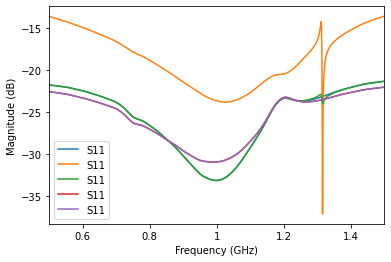

In [221]:
pink_circuit = make_pink_circuit()
blue_circuit = make_blue_circuit()
yellow_circuit = make_yellow_circuit()
red_circuit = make_red_circuit()
teal_circuit = make_teal_circuit()

pink_circuit.plot_s_db()
blue_circuit.plot_s_db()
yellow_circuit.plot_s_db()
red_circuit.plot_s_db()
teal_circuit.plot_s_db()

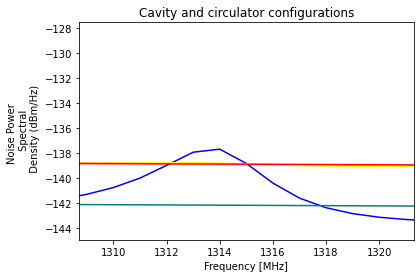

In [220]:
ntw_dict = {'pink': pink_circuit,'blue': blue_circuit,'yellow':yellow_circuit,'red':red_circuit,'teal':teal_circuit}
plot_power_spectrum_for_1p_ntw(ntw_dict,1315,12.6)

In [225]:
def make_circuits():
    """
    Makes networks for different circulator and cavity configurations
    """
    
    
    #Amplifier

    amp_path = '/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data'
    amp_name = 'ZX60-33LNR-S+_UNIT1_.s2p' #Our amplifier is ZX60-33LN-S+, gain of LNR ~0.1 dB less at 1 Ghz

    amp_sparam = return_ZX60_33LN_params(amp_path,amp_name,freq)

    noisy_ntw_amp_1 = amp_sparam
    noisy_ntw_amp_2 = amp_sparam

    #Cavity

    freq_cavity = 1.315e9 # Measured
    R_cavity= 1_000 # [[Not measured, what is a reasonable value for cavity resistance?]]
    Q_cavity= 666.23 # Measured

    start_freq = 0.5e9
    stop_freq = 1.5e9

    ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity) # [[What are the N's here?]]
    noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, Troom)

    #Circulator
    ntw_circ_1 = cmp.create_ideal_circulator2(freq)
    noisy_ntw_circ_1 = read_in_noisy_network(ntw_circ_1, freq, Troom)


    #Terminator
    ntw_termi_1 = cmp.create_terminator(freq,Gamma_0=0.048) # [[not measured]]
    noisy_ntw_termi_1 = read_in_noisy_network(ntw_termi_1, freq, Troom) 
    noisy_ntw_termi_cold = read_in_noisy_network(ntw_termi_1, freq, 77)

    ntw_termi_open = cmp.create_terminator(freq,Gamma_0=1)
    noisy_ntw_termi_open = read_in_noisy_network(ntw_termi_open, freq, Troom) 
    
    def make_pink_circuit():
        # Circuit diagram

        # (SA) - 1 - [circ] - 2 - 1 [open]
        #              3
        #              |
        #              1
        #           [termi]

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_termi_1,'termi')
        mnns.add(noisy_ntw_amp_1,'amp1')
        mnns.add(noisy_ntw_amp_2,'amp2')
        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_open,'open')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('open',1,'circ',2)
        mnns.connect('termi',1,'circ',3)
        mnns.connect('circ',1,'amp1',1)
        mnns.connect('amp1',2,'amp2',1)

        mnns.external_port('amp2',2,1)

        assem_mnns = mnns.reduce()

        return assem_mnns
    
    def make_blue_circuit():
        # Circuit diagram

        # (SA) - 1 - [circ] - 2 - 1 [cavity] 2 - 1 [termi]
        #              3
        #              |
        #              1
        #           [open]

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_cav,'cav')
        mnns.add(noisy_ntw_amp_1,'amp1')
        mnns.add(noisy_ntw_amp_2,'amp2')
        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_1,'termi1')
        mnns.add(noisy_ntw_termi_open,'open')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'cav',2)
        mnns.connect('cav',1,'circ',2)
        mnns.connect('circ',3,'open',1)
        mnns.connect('circ',1,'amp1',1)
        mnns.connect('amp1',2,'amp2',1)

        mnns.external_port('amp2',2,1)

        assem_mnns = mnns.reduce()

        return assem_mnns
    
    def make_yellow_circuit():
        # Circuit diagram

        # (SA) - 1 - [circ] - 2 - 1 [cavity] 2 - 1 [termi1]
        #              3
        #              |
        #              1
        #           [300k termi2]

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_cav,'cav')
        mnns.add(noisy_ntw_amp_1,'amp1')
        mnns.add(noisy_ntw_amp_2,'amp2')
        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_1,'termi1')
        mnns.add(noisy_ntw_termi_1,'termi2')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'cav',2)
        mnns.connect('cav',1,'circ',2)
        mnns.connect('circ',3,'termi2',1)
        mnns.connect('circ',1,'amp1',1)
        mnns.connect('amp1',2,'amp2',1)

        mnns.external_port('amp2',2,1)

        assem_mnns = mnns.reduce()

        return assem_mnns
    
    def make_red_circuit():
        # Circuit diagram

        # (SA) - 1 - [circ] - 2 - 1 [termi1]
        #              3
        #              |
        #              1
        #           [300k termi2]

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_amp_1,'amp1')
        mnns.add(noisy_ntw_amp_2,'amp2')
        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_1,'termi1')
        mnns.add(noisy_ntw_termi_1,'termi2')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'circ',2)

        mnns.connect('circ',3,'termi2',1)
        mnns.connect('circ',1,'amp1',1)
        mnns.connect('amp1',2,'amp2',1)

        mnns.external_port('amp2',2,1)

        assem_mnns = mnns.reduce()

        return assem_mnns
    
    def make_teal_circuit():
        # Circuit diagram

        # (SA) - 1 - [circ] - 2 - 1 [termi1]
        #              3
        #              |
        #              1
        #           [77k termi2]

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_amp_1,'amp1')
        mnns.add(noisy_ntw_amp_2,'amp2')
        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_1,'termi1')
        mnns.add(noisy_ntw_termi_cold,'termi_cold')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'circ',2)
        mnns.connect('circ',3,'termi_cold',1)
        mnns.connect('circ',1,'amp1',1)
        mnns.connect('amp1',2,'amp2',1)

        mnns.external_port('amp2',2,1)

        assem_mnns = mnns.reduce()

        return assem_mnns

        
    # Create circuits
    
    pink_circuit = make_pink_circuit()
    blue_circuit = make_blue_circuit()
    yellow_circuit = make_yellow_circuit()
    red_circuit = make_red_circuit()
    teal_circuit = make_teal_circuit()
    
    # return dictionary for plotting
    
    ntw_dict = {'pink': pink_circuit,'blue': blue_circuit,'yellow':yellow_circuit,'red':red_circuit,'teal':teal_circuit}
    
    return ntw_dict
        
    

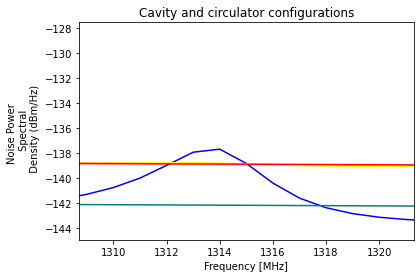

In [226]:
ntw_dict = make_circuits()
plot_power_spectrum_for_1p_ntw(ntw_dict,1315,12.6)